In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

import sys
sys.path.append(r'../')

In [2]:
from pyhmesh import SurfaceMesh

In [335]:
mesh = SurfaceMesh()
mesh.generate('model_test.step')

nd = 1000
dx = mesh.length/nd
print('nd=',nd)
print('dx=',dx)

domain_image =  mesh.voxlize(dx=dx)
mesh.close()

Reading model_test.step...
Model dimension= 2
domain 11
boundary 11
nd= 1000
dx= 0.020000000200000003
Get nodes from 13 boundary entites
Get eles from 13 boundary entites
Convert polymesh to image.....
Image Origin= [0.0, 0.0, -0.020000000200000003]
Image Shape= [1000  500    1]
Image Extent= [  0 999   0 499   0   0]


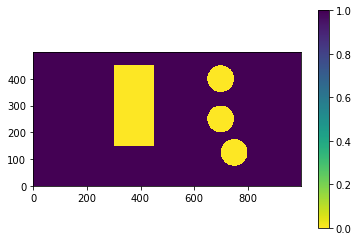

In [307]:
domain_image=np.squeeze(domain_image)
domain_image = domain_image>0

plt.imshow(domain_image,cmap=plt.cm.viridis_r,origin="lower",interpolation='nearest')
plt.colorbar()
plt.show()

In [308]:
from skimage import data
from skimage.util import invert
from skimage.morphology import skeletonize,medial_axis
from scipy import ndimage as ndi

domain_pad = np.pad(domain_image,1,constant_values=False)

#ma_skel = skeletonize(domain_pad, method='zhang')
ma_skel = skeletonize(domain_pad, method='lee') #this is support 3d as well
#ma_skel = medial_axis(domain_pad)
ma_skel = invert(ma_skel)
ma_skel[ma_skel != 0] = 1 #normalize to binary

ma_mask=ma_skel==0

In [333]:
phi_MA = ndi.distance_transform_edt(ma_skel)
phi_bd = ndi.distance_transform_edt(domain_pad)

phi_feature = phi_MA+phi_bd
print(phi_feature.min()*dx,phi_feature.max()*dx)

import porespy as ps

thk_feature = ps.filters.local_thickness(domain_pad, mode='dt')
print(thk_feature.min()*dx,thk_feature.max()*dx)

0.32062439404387194 4.285090473635301


0.0 2.450283320858362


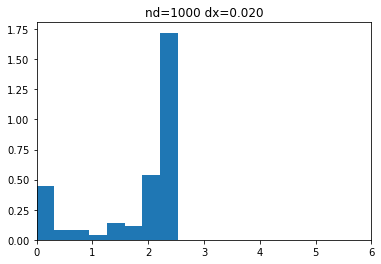

In [321]:
plt.hist(thk_feature.flatten()*dx,bins,density=True)
plt.xlim(0,6)
plt.title(f"nd={nd} dx={dx:.3f}")
plt.show()

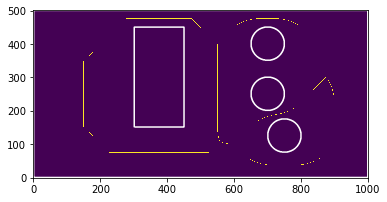

In [310]:
plt.imshow(ma_skel,cmap=plt.cm.viridis_r,origin="lower",interpolation='nearest')
plt.contour(domain_pad,[0.5],colors='w')
plt.show()

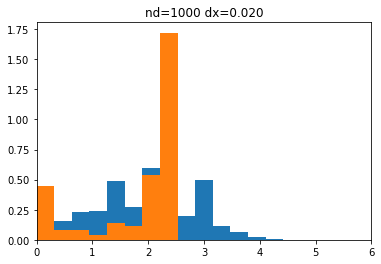

In [334]:
plt.hist(phi_feature.flatten()*dx,bins,density=True)
plt.hist(thk_feature.flatten()*dx,bins,density=True)
plt.xlim(0,6)
plt.title(f"nd={nd} dx={dx:.3f}")
plt.show()

In [ ]:
hist_data={}

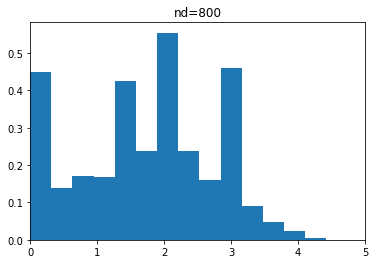

In [285]:
bins = np.linspace(0, 6, 20)
hist_data[nd] = plt.hist(phi_feature.flatten()*dx,bins,density=True)
plt.xlim(0,5)
plt.title(f"nd={nd}")
plt.show()

In [175]:
def chi2_distance(histA, histB, eps = 1e-10):
	# compute the chi-squared distance
	d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
		for (a, b) in zip(histA, histB)])
	# return the chi-squared distance
	return d

In [312]:
#Grid convergence for the feature map
print("Grid Convergence")
print("nd similarity")
#https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
for k,v in hist_data.items():
    print(k,1.0-chi2_distance(hist_data[k][0],hist_data[1000][0]))

Grid Convergence
nd similarity
100 0.6819885862184889
200 0.9106091201508444
400 0.9945108818638824
800 0.752394356053737
1000 1.0


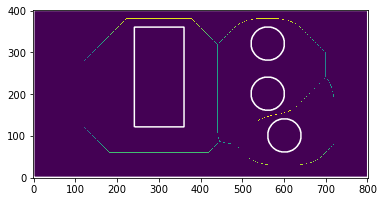

In [277]:
thickness_skel = np.array(phi_feature)
thickness_skel[~ma_mask]=phi_feature.max()+1
plt.imshow(thickness_skel,cmap=plt.cm.viridis_r,origin="lower",interpolation='nearest')
plt.contour(domain_pad,[0.5],colors='w')
plt.show()

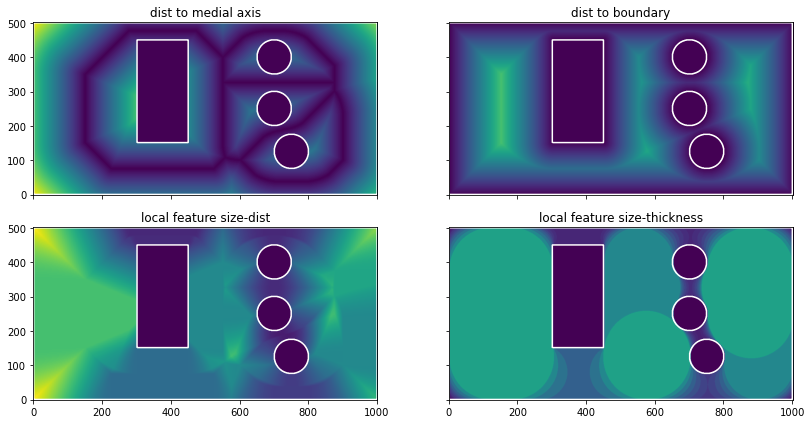

In [328]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

phi_MA[~domain_pad]=0.0
ax[0].imshow(phi_MA, cmap=plt.cm.viridis,origin="lower",
             vmin = 0, vmax = phi_feature.max())
ax[0].contour(domain_pad,[0.5],colors='w')
ax[0].set_title('dist to medial axis')

phi_bd[~domain_pad]=0.0
ax[1].imshow(phi_bd, cmap=plt.cm.viridis,origin="lower",
             vmin = 0, vmax = phi_feature.max())
ax[1].contour(domain_pad,[0.5],colors='w')
ax[1].set_title('dist to boundary')

phi_feature[~domain_pad]=0.0
ax[2].imshow(phi_feature, cmap=plt.cm.viridis,origin="lower",
             vmin = 0, vmax = phi_feature.max())
ax[2].contour(domain_pad,[0.5],colors='w')
ax[2].set_title('local feature size-dist')

thk_feature[~domain_pad]=0.0
ax[3].imshow(thk_feature, cmap=plt.cm.viridis,origin="lower",
             vmin = 0, vmax = phi_feature.max())
ax[3].contour(domain_pad,[0.5],colors='w')
ax[3].set_title('local feature size-thickness')

fig.tight_layout()
plt.show()

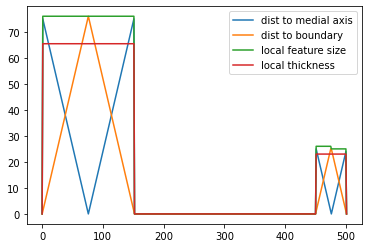

In [332]:
plt.plot(phi_MA[:,400])
plt.plot(phi_bd[:,400])
plt.plot(phi_feature[:,400])
plt.plot(thk_feature[:,400])

plt.legend(['dist to medial axis','dist to boundary','local feature size','local thickness'])

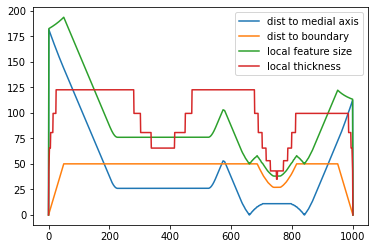

In [331]:
plt.plot(phi_MA[50,:])
plt.plot(phi_bd[50,:])
plt.plot(phi_feature[50,:])
plt.plot(thk_feature[50,:])

plt.legend(['dist to medial axis','dist to boundary','local feature size','local thickness'])